<a href="https://colab.research.google.com/github/kaleem500bc/Batch-encoder-decoder-translation/blob/main/Batch_Seq_Seq_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.manythings.org/anki/deu-eng.zip -O german-eng.zip
!unzip german-eng.zip

--2020-11-30 08:35:09--  https://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.108.196, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8440213 (8.0M) [application/zip]
Saving to: ‘german-eng.zip’

german-eng.zip      100%[===================>]   8.05M  18.9MB/s    in 0.4s    

2020-11-30 08:35:10 (18.9 MB/s) - ‘german-eng.zip’ saved [8440213/8440213]

Archive:  german-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [31]:
from io import open 
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
import string
import numpy as np
from matplotlib import pyplot as plt
from termcolor import colored

In [2]:
data = open("/content/deu.txt").read()
dataSplit = data.split('\n')

In [3]:
longest_sent = 0
j = 0
ind = 0
def normalize(x):
  global longest_sent, j
  for i in range(len(x)):
    x[i] = x[i].lower().strip(string.punctuation)
    x[i] = re.sub(r"([.!?])", r" \1", x[i])
    x[i] = re.sub(r"[^a-zA-Z.!\x7f-\xff?]+", r" ", x[i])
    temp = len(x[i].split())
    if longest_sent < temp:
      longest_sent = temp
      ind = j
  j += 1

  return x

In [4]:
text_data =np.array([ normalize(dataSplit[i].split('\t')[:2]) for i in range(
    len(dataSplit))][:-1])
np.random.shuffle(text_data)

In [5]:
eng_vocab = set([
         word 
         for sentence in text_data[:,0] # All sentences
         for word in sentence.split() 
         ])
deut_vocab = set([
         word 
         for sentence in text_data[:,1] # All sentences
         for word in sentence.split() 
         ])
vocab_size = len(deut_vocab)+3
eng_word2int = { word:i+1 for i,word in enumerate(eng_vocab)}
deut_word2int = { word:i+3 for i,word in enumerate(deut_vocab)}
deut_word2int['<sos>'] = 1
deut_word2int['<eos>'] = 2
eng_int2word = {eng_word2int[key]:key for key in eng_word2int}
deut_int2word = {deut_word2int[key]:key for key in deut_word2int}

In [6]:
def word2intFunc(x_y):
  x,y = x_y[0],x_y[1]
  x = torch.tensor([eng_word2int[w] for w in x.split()], dtype=torch.long)
  y = torch.tensor([deut_word2int[w] for w in ("<sos> " + y + " <eos>").split()], 
                   dtype = torch.long)
  offsets = x.shape[0]
  return [x,y, offsets]

encoded_data = [word2intFunc(d) for d in text_data]

In [7]:
class Dataset(torch.utils.data.Dataset):

  def __init__(self, encoded_data):
    self.data = encoded_data

  def __getitem__(self,idx):
    source_target = self.data[idx]
    return source_target

  
  def __len__(self):
    return len(self.data)



In [8]:
def get_batch(batch):
  source = [b[0] for b in batch]
  target = [b[1] for b in batch]
  offset = torch.tensor([b[2] for b in batch])
  source = nn.utils.rnn.pad_sequence(source, batch_first=True)
  target = nn.utils.rnn.pad_sequence(target,batch_first=True)
  return source, target, offset


In [9]:
batch_size = 256
dataset = Dataset(encoded_data)
test_offset = int(len(dataset)*0.2)
testset = dataset[:test_offset]
dataset = dataset[test_offset:]
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, collate_fn=get_batch)

In [10]:
class Encoder(nn.Module):
  def __init__(self, vocab_size,layers = 1,bdr = False, hidden=512,batch_size = 1,embedd_dim = 512):
    super().__init__()
    self.num_layers = layers
    self.batch_size = batch_size
    self.bdr = bdr
    self.hidden = hidden
    self.embedd_dim = embedd_dim
    self.Embeddings = nn.Embedding(vocab_size,embedd_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedd_dim,hidden_size=hidden,num_layers=layers,batch_first=True, bidirectional=bdr)
  
  def forward(self,x,offsets,h_cell):
    # input shape is batch x seq_length x input_size
    x = F.relu(self.Embeddings(x))
    # input shape for lstm is batch x seq_len x input_size
    x = x.view(x.shape[0],x.shape[1],self.embedd_dim)
    x = nn.utils.rnn.pack_padded_sequence(x,offsets,enforce_sorted=False,batch_first=True)
    x, h_cell = self.lstm(x,h_cell)
    return x,h_cell

class Decoder(nn.Module):
  def __init__(self, vocab_size,layers = 1,bdr = False, hidden=512,batch_size = 1,embedd_dim = 512):
    super().__init__()
    self.num_layers = layers
    self.batch_size = batch_size
    self.bdr = bdr
    self.hidden = hidden
    # self.embedd_dim = embedd_dim
    # self.Embeddings = nn.Embedding(vocab_size,embedd_dim)
    self.lstm = nn.LSTM(1, hidden_size=hidden, num_layers = layers,batch_first=True, bidirectional = bdr)
    self.linear = nn.Linear(hidden*(1+bdr), vocab_size)

  def forward(self, x, hidden,batch_size):
    # x = F.relu(self.Embeddings(x))
    # x = x.view(batch_size, x.shape[0], 1)
    x, hidden = self.lstm(x, hidden)
    x = x.view(x.shape[0],-1)
    x = self.linear(x)
    return x,hidden

def init_hidden(model, batch_size):
  for layer,weight in zip(model.modules(),model.parameters()):
    if type(layer) == nn.LSTM:
      hidden = (torch.zeros((model.num_layers*(model.bdr+1), batch_size, model.hidden),dtype=torch.float).to("cuda"),
                torch.zeros((model.num_layers*(model.bdr+1), batch_size, model.hidden),dtype=torch.float).to("cuda"))
  return hidden

From https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
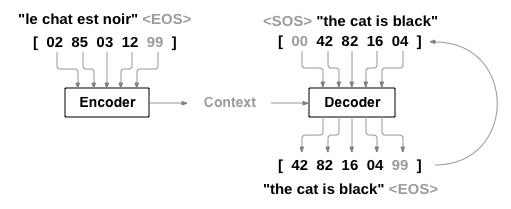

In [11]:
hidden_size = 256

encoder = Encoder(vocab_size, batch_size=batch_size, layers = 2, bdr=True, hidden=hidden_size)
decoder = Decoder(vocab_size, batch_size=batch_size, layers = 2, bdr=True, hidden = hidden_size)
criterion = nn.CrossEntropyLoss()
encoder.to("cuda")
decoder.to("cuda")

Decoder(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=35017, bias=True)
)

In [14]:
enc_optimizer = torch.optim.SGD(encoder.parameters(),lr = 0.02, momentum=0.9)
dec_optimizer = torch.optim.SGD(decoder.parameters(),lr = 0.02, momentum=0.9)

def train(epoch, teacher_forcing):

  loss_epoch = []
  
  for e in range(epoch):

    total_loss = 0
    b = 0
    loss = 0

    for x, y, offsets in dataloader:

      x = x.to("cuda")
      y = y.to("cuda")
      hidden = init_hidden(encoder,x.shape[0])
      _, context = encoder(x,offsets, hidden)
      dec_out = torch.ones((x.shape[0],1,1), dtype = torch.float).to("cuda")

      for i in range(y.shape[1]-1):

        dec_out, context = decoder(dec_out, context,x.shape[0])

        loss += criterion(dec_out,y[:,i+1])

        # Using teacher forcing
        if teacher_forcing < random.random():
          dec_out = y[:,i+1].view(x.shape[0],1,1).float()
        else:
          # Without teacher forcing
          dec_out = torch.argmax(dec_out,dim=1).view(x.shape[0],1,1).float()

      total_loss += loss.item()
      enc_optimizer.zero_grad()
      dec_optimizer.zero_grad()

      loss.backward()

      enc_optimizer.step()
      dec_optimizer.step()
      
      loss = 0
    print("Loss per Epoch {}: ".format(e),total_loss)
    loss_epoch.append(total_loss)
  return loss_epoch

In [ ]:
loss_epoch = train(10,0.2)

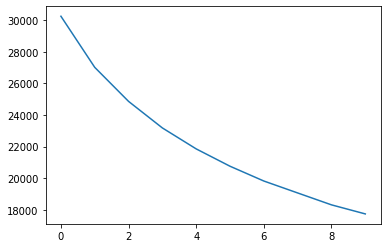

In [18]:
plt.plot(loss_epoch)

In [23]:
def translate(x,offset):
  hidden = init_hidden(encoder,1)
  _, context = encoder(x, offset,hidden)
  dec_out = torch.tensor([2], dtype = torch.float)
  loss = 0
  s = ""
  for i in range(50):
    dec_out, context = decoder(dec_out.view(1,1,1).to("cuda"), context,1)
    # target = one_hot_vector(y[i+1])
    # loss += criterion(dec_out.unsqueeze(0),torch.as_tensor([y[i+1]],dtype=torch.long))

    dec_out = torch.argmax(dec_out).float()
    if dec_out.item() != 0:
      if deut_int2word[dec_out.item()] == '<eos>':
        break
      s +=  deut_int2word[dec_out.item()] + " "
    
  return s


In [36]:
r =  618
for i in range(r,r+10):
  x,y,offset = testset[i]
  inpt= x.view(1,x.shape[0]).to("cuda")
  offset = torch.tensor(offset,device="cuda")
  s = translate(inpt,[offset])

  print(colored(" ".join([eng_int2word[i.item()] for i in x]), color="red"),colored(s,color="blue"),colored(" ".join([deut_int2word[i.item()] for i in y]),color="white"))

the store is open all the year round der laden ist das ganze ganze lang  <sos> der laden ist das ganze jahr lang geöffnet <eos>
we ve already met wir haben schon schon  <sos> wir haben uns schon kennengelernt <eos>
they re going to be ok sie werden okay sein  <sos> sie werden okay sein <eos>
i bought lots of books ich habe viele bücher bücher  <sos> ich habe jede menge bücher gekauft <eos>
this cloth feels like velvet diese stoff geht sich sich  <sos> dieser stoff fühlt sich samtig an <eos>
what made you think tom hasn t done that was hat dich an tom tom das das das hat  <sos> was brachte euch denn auf den gedanken tom hätte das nicht getan <eos>
the stars were beginning to appear die polizei waren sich  <sos> langsam kamen die sterne zum vorschein <eos>
tom was definitely afraid tom war angst angst angst  <sos> tom hatte definitiv angst <eos>
it was an informal meeting es war eine sitzung  <sos> das war ein formloses zusammentreffen <eos>
you handled that very skillfully du hast das s